In [1]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def plot_predictions(model, X_test, Y_test):
  T = X_test.shape[1]
  D = X_test.shape[2]

  validation_target = Y_test
  validation_predictions_one_step = []
  validation_predictions_future_forecast = []
  
  # one step prediction
  for t in X_test:
    pred = model.predict(t.reshape(1,T,D))
    prediction = pred[0,0]
    validation_predictions_one_step.append(prediction)
    
  # future predictions
  x = X_test[0]
  for t in X_test:
    pred = model.predict(x.reshape(1,T,D))
    prediction = pred[0,0]
    validation_predictions_future_forecast.append(prediction)
    x[:-1,:] = x[1:,:]
    x[-1,:] = prediction


  # plot
  plt.figure(figsize=(40,10))
  plt.subplot(1,2,1)
  plt.plot(validation_target, label='forecast target')
  plt.plot(validation_predictions_one_step, label='forecast prediction')
  plt.title('One Step Prediction')
  plt.legend();

  plt.subplot(1,2,2)
  plt.plot(validation_target, label='forecast target')
  plt.plot(validation_predictions_future_forecast, label='forecast prediction')
  plt.title('Long term prediction')
  plt.legend();

  plt.show()

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [4]:
series = df['close'].values.reshape(-1, 1)
series_val_idx = -1 * series.shape[0] // 2
scaler = StandardScaler()
scaler.fit(series[:-series.shape[0]//2])
series = scaler.transform(series).flatten()

In [5]:
T = 10
N = len(series)
D = 1
M = 5
idx = -N//2

X = []
Y = []
for t in range(N-T):
  X.append(series[t:t+T])
  Y.append(series[t+T])

X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)

print('X shape:', X.shape, ', Y shape:', Y.shape)

X shape: (1249, 10, 1) , Y shape: (1249,)


Epoch 1/100
20/20 [==============================] - 6s 85ms/step - loss: 0.4782 - val_loss: 0.8765
Epoch 2/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0237 - val_loss: 0.0616
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0786
Epoch 4/100
20/20 [==============================] - 0s 17ms/step - loss: 0.0062 - val_loss: 0.0250
Epoch 5/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0073 - val_loss: 0.0239
Epoch 6/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0314
Epoch 8/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0397
Epoch 9/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0063 - val_loss: 0.0376
Epoch 10/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0323

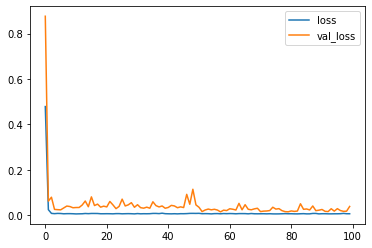

In [6]:
i = Input((T, D))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))
history = model.fit(X[:idx], Y[:idx], epochs=100, validation_data=(X[idx:], Y[idx:]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend();

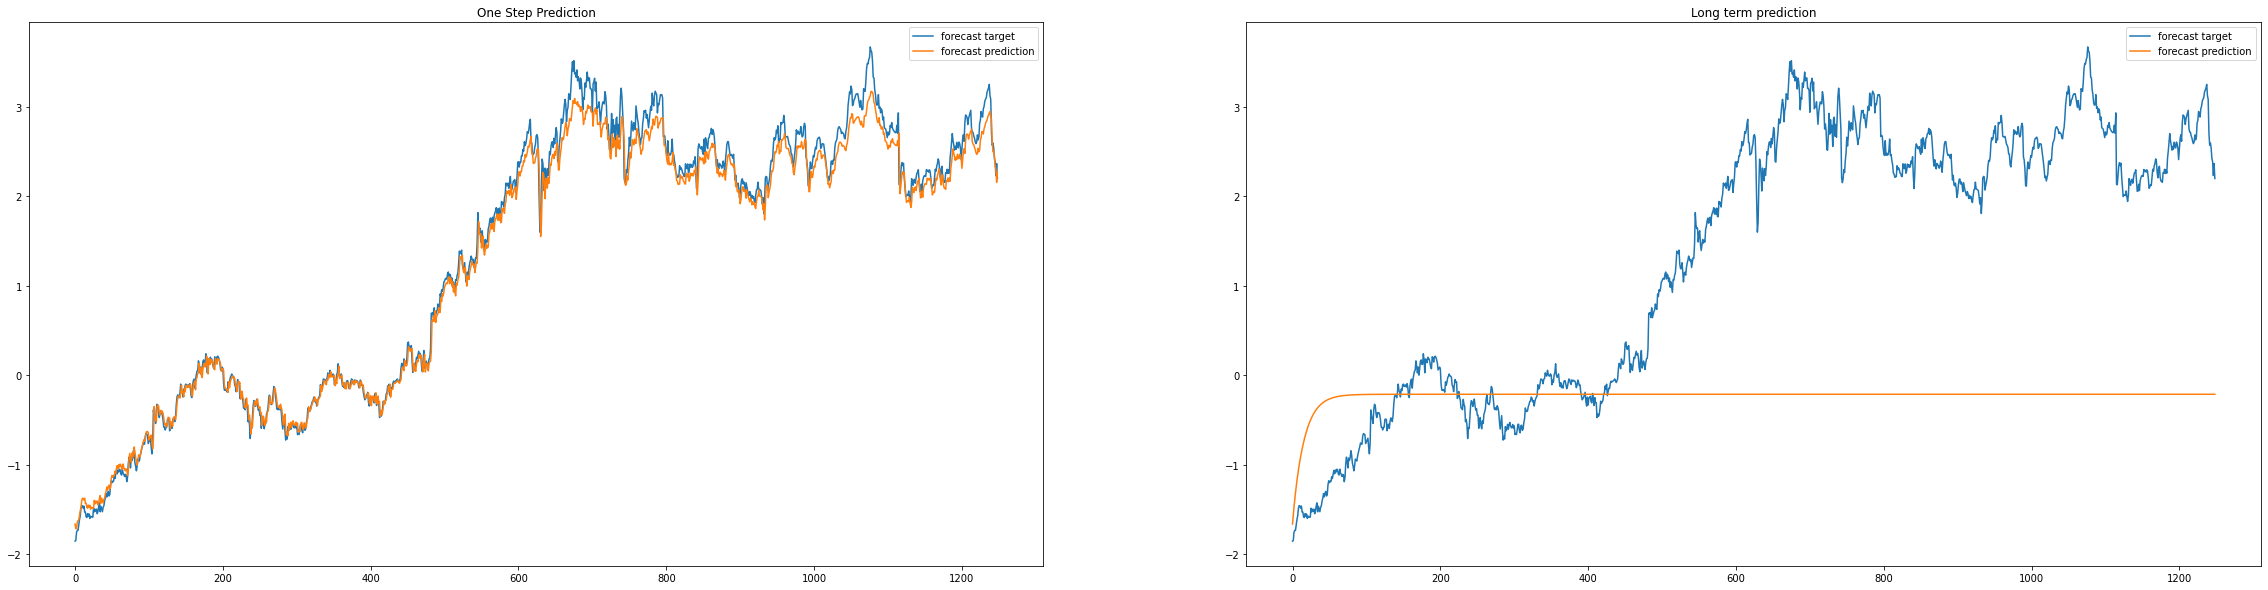

In [7]:
plot_predictions(model, X, Y)

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


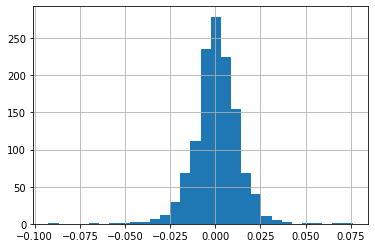

In [8]:
df['PrevClose'] = df['close'].shift(1)
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df['Return'].hist(bins=30);
df.head()

In [9]:
series_return = df['Return'].values[1:].reshape(-1, 1)
scaler_return = StandardScaler()
scaler_return.fit(series_return[:-len(series_return)//2])
series_return = scaler_return.transform(series_return).flatten()

In [10]:
T = 10
N = len(series_return)
D = 1
M = 5
idx = -N//2

X = []
Y = []
for t in range(N-T):
  X.append(series_return[t:t+T])
  Y.append(series_return[t+T])

X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)

print('X shape:', X.shape, ', Y shape:', Y.shape)

X shape: (1248, 10, 1) , Y shape: (1248,)


Epoch 1/100
20/20 [==============================] - 3s 34ms/step - loss: 1.0038 - val_loss: 1.1338
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.9952 - val_loss: 1.1486
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9903 - val_loss: 1.1384
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9910 - val_loss: 1.1398
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9894 - val_loss: 1.1456
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.9949 - val_loss: 1.1485
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9909 - val_loss: 1.1352
Epoch 8/100
20/20 [==============================] - 0s 10ms/step - loss: 0.9927 - val_loss: 1.1437
Epoch 9/100
20/20 [==============================] - 0s 11ms/step - loss: 0.9917 - val_loss: 1.1447
Epoch 10/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9909 - val_loss: 1.1389
Epoc

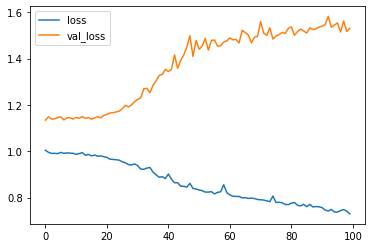

In [11]:
i = Input((T, D))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01))
history = model.fit(X[:idx], Y[:idx], epochs=100, validation_data=(X[idx:], Y[idx:]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend();

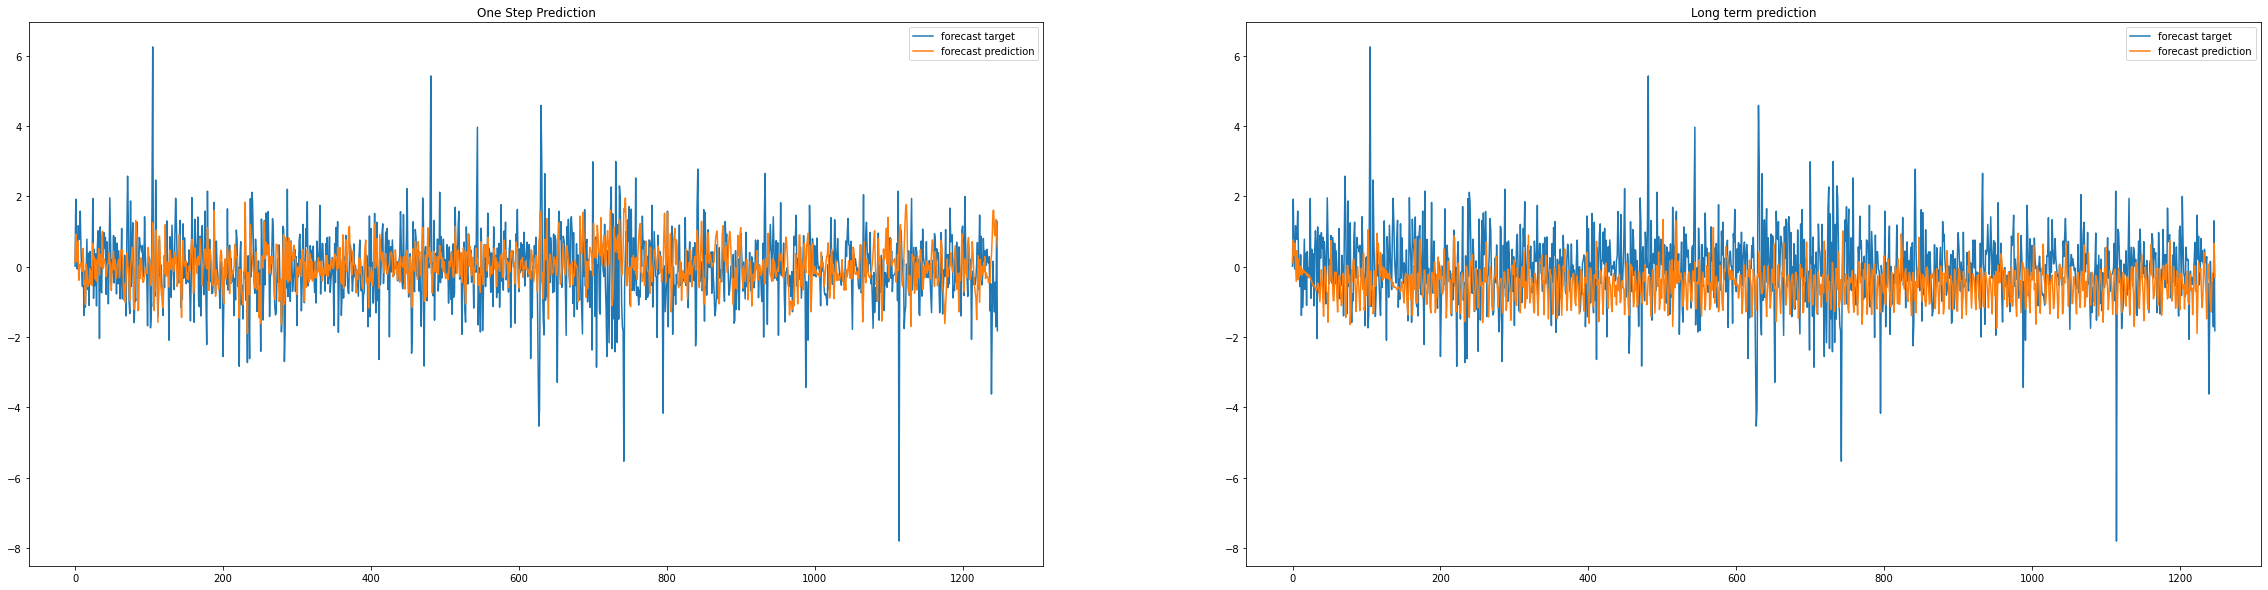

In [12]:
plot_predictions(model, X, Y)

In [13]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

T = 10
D = input_data.shape[1]
N = len(input_data) - T
M = 50

Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)


X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


27/27 [==============================] - 3s 28ms/step - loss: 0.6980 - accuracy: 0.4934 - val_loss: 0.6912 - val_accuracy: 0.5439
Epoch 2/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6941 - accuracy: 0.4875 - val_loss: 0.6916 - val_accuracy: 0.5415
Epoch 3/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6922 - accuracy: 0.5125 - val_loss: 0.6961 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6928 - accuracy: 0.5161 - val_loss: 0.6949 - val_accuracy: 0.4927
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6915 - accuracy: 0.5292 - val_loss: 0.7009 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6905 - accuracy: 0.5459 - val_loss: 0.6917 - val_accuracy: 0.4829
Epoch 7/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6897 - accuracy: 0.5328 - val_loss: 0.6910 - val_accuracy: 0.5146
Epoch 8/300
27/27 [

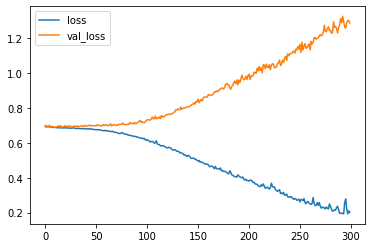

In [14]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=32, epochs=300, validation_data=(X_test, Y_test))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend();

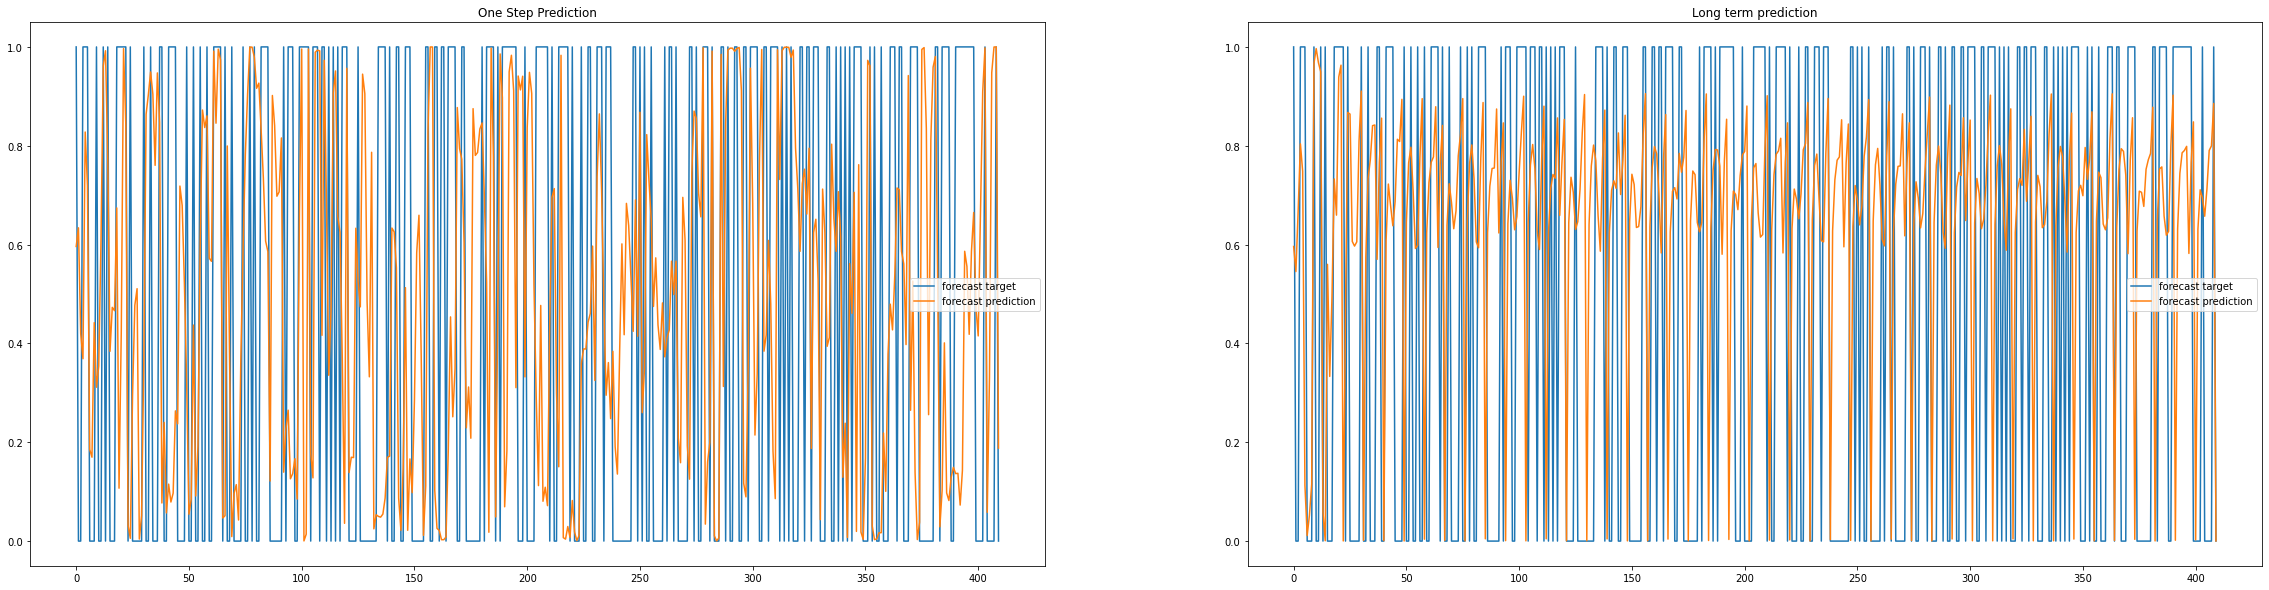

In [15]:
plot_predictions(model, X_test, Y_test)